In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import transform_strokes, inverse_transform_strokes, get_n_points
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.plot import get_canvas, plot, get_animation
from lib.model import Decoder
from lib.model import train, evaluate, reconstruction_loss
from lib.model import extract_start_of_stroke, generate

# Load and show dataset

In [4]:
#dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = unpack_drawings('./data/cat.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

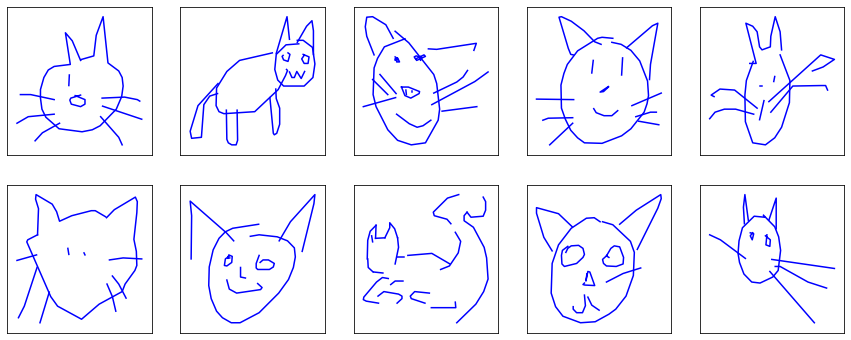

In [6]:
fig, axarr = get_canvas(2, 5)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

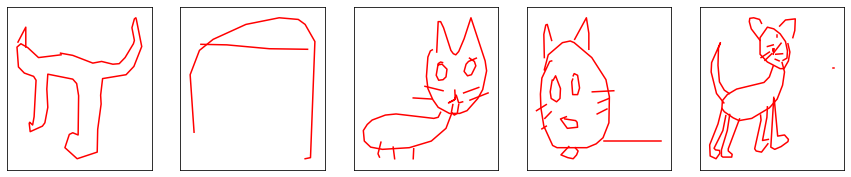

In [7]:
fig, axarr = get_canvas(1, 5)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'delta_y')

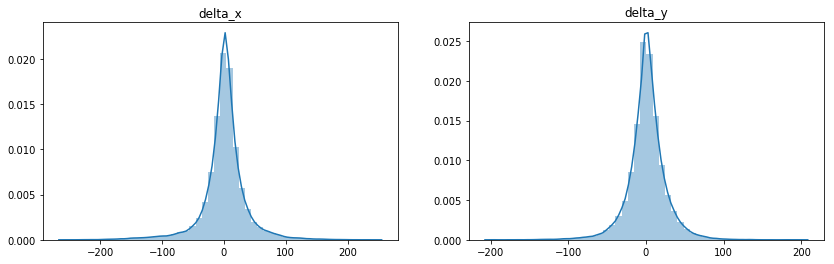

In [10]:
# Transformed stroke coordinates follow a gaussian distribution.

transformed_drawings = [transform_strokes(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

# Create pytorch dataset

In [11]:
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transform_strokes(drawing) for drawing in drawings]

In [12]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [13]:
ds = get_dataset(transformed_drawings)

In [14]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.2)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(15540, 5084)

In [15]:
train_means_stds = get_means_stds(train_ds)
val_means_stds = get_means_stds(val_ds)

In [16]:
# Debug batches generation

train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lengths_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lengths_batch):
    print(tensor)
    print()

torch.Size([173, 2, 5]) torch.Size([173, 2, 5]) torch.Size([2])


tensor([[[-0.7707,  0.8428,  1.0000,  0.0000,  0.0000],
         [ 0.1510, -0.2843,  1.0000,  0.0000,  0.0000]],

        [[-0.6311,  1.3258,  1.0000,  0.0000,  0.0000],
         [ 0.2348, -0.0830,  1.0000,  0.0000,  0.0000]],

        [[ 1.1286, -2.1360,  0.0000,  1.0000,  0.0000],
         [ 0.5141,  0.6013,  1.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])

tensor([[[-0.6311,  1.3258,  1.0000,  0.0000,  0.0000],
         [ 0.2348, -0.0830,  1.0000,  0.0000,  0.0000]],

        [[ 1.1286, -2.1360,  0.0000,  1.0000,  0.0000],
         [ 0.5141,  0.6013,  1.0000,  0.0000,  0.0000]],

       

In [17]:
# Debug model forward

model = Decoder(dim_hidden=5, n_gaussians=3)

if torch.cuda.is_available():
    model = model.cuda()

train_batches = get_batches(train_ds, train_means_stds, batch_size=1024)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

gmm_params, strokes_state_params, lstm_states = model(data_batch, lengths_batch)

In [18]:
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
hidden_state, cell_state = lstm_states

print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)

print(strokes_state_params.shape)

print(hidden_state.shape, cell_state.shape)

torch.Size([146, 1024, 3])
torch.Size([146, 1024, 3]) torch.Size([146, 1024, 3])
torch.Size([146, 1024, 3]) torch.Size([146, 1024, 3]) torch.Size([146, 1024, 3])
torch.Size([146, 1024, 3])
torch.Size([1, 1024, 5]) torch.Size([1, 1024, 5])


In [19]:
# Debug loss
reconstruction_loss(gmm_params, strokes_state_params, labels_batch, lengths_batch)

tensor(3.9963, grad_fn=<AddBackward0>)

In [20]:
# Debug generation
start_of_stroke = extract_start_of_stroke(train_ds, n_points=2)
generate(model, start_of_stroke, n_points=3)

tensor([[ 1.3241, -0.4453,  1.0000,  0.0000,  0.0000],
        [ 1.6872, -0.0428,  1.0000,  0.0000,  0.0000],
        [-0.2356,  0.1120,  0.0000,  1.0000,  0.0000],
        [-0.6796,  0.4155,  0.0000,  1.0000,  0.0000],
        [ 0.1764, -1.8567,  0.0000,  1.0000,  0.0000]])

# Train

In [24]:
batch_size = 512
dim_hidden = 128
n_gaussians = 12

model = Decoder(dim_hidden, n_gaussians)
if torch.cuda.is_available():
    model = model.cuda()

criterion = reconstruction_loss
optimizer = Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [25]:
print(model)

Decoder(
  (lstm): LSTM(5, 128)
  (output_weights): Linear(in_features=128, out_features=39, bias=True)
)


In [29]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 3.79875   val_loss: 3.84177
epoch:  10   train_loss: 3.55826   val_loss: 3.66431
epoch:  20   train_loss: 3.20305   val_loss: 3.34182
epoch:  30   train_loss: 3.06523   val_loss: 3.27807
Epoch    37: reducing learning rate of group 0 to 1.0000e-04.
epoch:  40   train_loss: 2.91454   val_loss: 3.38310


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/quentin/anaconda3/envs/draw/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-e487f97e4a9f>", line 2, in <module>
    epochs=100, epochs_between_evals=10)
  File "/home/quentin/travail/divers/dl/draw/lib/model.py", line 235, in train
    loss.backward()
  File "/home/quentin/anaconda3/envs/draw/lib/python3.7/site-packages/torch/tensor.py", line 102, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/home/quentin/anaconda3/envs/draw/lib/python3.7/site-packages/torch/autograd/__init__.py", line 90, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/quentin/anaconda3/envs/draw/lib/python3.7/site-packages/IPython/core/interactiveshell.py

KeyboardInterrupt: 

In [36]:
torch.save(model.state_dict(), 'cat1.pth')

In [39]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.28528   val_loss: 1.31888
epoch:  10   train_loss: 1.26405   val_loss: 1.30071
epoch:  20   train_loss: 1.24260   val_loss: 1.28274
epoch:  30   train_loss: 1.22335   val_loss: 1.26712
epoch:  40   train_loss: 1.20630   val_loss: 1.25375
epoch:  50   train_loss: 1.19107   val_loss: 1.24236
epoch:  60   train_loss: 1.17765   val_loss: 1.23291
epoch:  70   train_loss: 1.16600   val_loss: 1.22539
epoch:  80   train_loss: 1.15436   val_loss: 1.21740
epoch:  90   train_loss: 1.14281   val_loss: 1.20973
epoch: 100   train_loss: 1.13096   val_loss: 1.20128


In [40]:
torch.save(model.state_dict(), 'cat2.pth')

In [41]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.13005   val_loss: 1.20079
epoch:  10   train_loss: 1.12052   val_loss: 1.19430
epoch:  20   train_loss: 1.11144   val_loss: 1.18858
epoch:  30   train_loss: 1.10304   val_loss: 1.18344
epoch:  40   train_loss: 1.09545   val_loss: 1.17913
epoch:  50   train_loss: 1.08863   val_loss: 1.17566
epoch:  60   train_loss: 1.08273   val_loss: 1.17251
epoch:  70   train_loss: 1.07534   val_loss: 1.16819
epoch:  80   train_loss: 1.07082   val_loss: 1.16674
epoch:  90   train_loss: 1.06753   val_loss: 1.16651
epoch: 100   train_loss: 1.05984   val_loss: 1.16244


In [42]:
torch.save(model.state_dict(), 'cat3.pth')

In [97]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.05941   val_loss: 1.16231
epoch:  10   train_loss: 1.05600   val_loss: 1.16145
epoch:  20   train_loss: 1.05034   val_loss: 1.15736
epoch:  30   train_loss: 1.04291   val_loss: 1.15366
epoch:  40   train_loss: 1.03638   val_loss: 1.14987
epoch:  50   train_loss: 1.03121   val_loss: 1.14718
epoch:  60   train_loss: 1.02664   val_loss: 1.14578
epoch:  70   train_loss: 1.02221   val_loss: 1.14410
epoch:  80   train_loss: 1.01785   val_loss: 1.14227
epoch:  90   train_loss: 1.01403   val_loss: 1.14115
epoch: 100   train_loss: 1.01295   val_loss: 1.14058


In [98]:
torch.save(model.state_dict(), 'cat4.pth')

In [99]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.00910   val_loss: 1.13809
epoch:  10   train_loss: 1.01388   val_loss: 1.14392
Epoch   411: reducing learning rate of group 0 to 1.0000e-04.
epoch:  20   train_loss: 0.98588   val_loss: 1.12349
Epoch   425: reducing learning rate of group 0 to 1.0000e-05.
epoch:  30   train_loss: 0.98375   val_loss: 1.12267
Epoch   437: reducing learning rate of group 0 to 1.0000e-06.
epoch:  40   train_loss: 0.98364   val_loss: 1.12289
Epoch   448: reducing learning rate of group 0 to 1.0000e-07.
epoch:  50   train_loss: 0.98362   val_loss: 1.12294
Epoch   459: reducing learning rate of group 0 to 1.0000e-08.
epoch:  60   train_loss: 0.98362   val_loss: 1.12295
epoch:  70   train_loss: 0.98362   val_loss: 1.12295
epoch:  80   train_loss: 0.98362   val_loss: 1.12295
epoch:  90   train_loss: 0.98362   val_loss: 1.12295
epoch: 100   train_loss: 0.98362   val_loss: 1.12295


In [100]:
torch.save(model.state_dict(), 'cat5.pth')

# Predict

In [31]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load('cat5.pth', map_location=map_location))

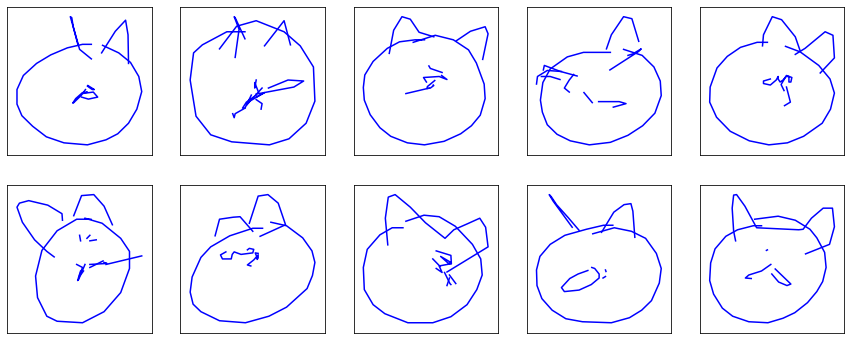

In [34]:
fig, axarr = get_canvas(2, 5)

start_of_stroke = extract_start_of_stroke(val_ds, n_points=1)

all_preds_strokes = []
for i, ax in enumerate(axarr.flatten()):
    pred_flat_strokes = generate(model, start_of_stroke, n_points=50)
    pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
    pred_strokes = inverse_transform_strokes(pred_flat_strokes)
    all_preds_strokes.append(pred_strokes)
    plot(pred_strokes, color='b', ax=ax)

In [28]:
%%capture
pred_anim = get_animation(all_preds_strokes[3])

In [29]:
# Generated drawing
HTML(pred_anim.to_html5_video())

In [30]:
pred_anim.save('generated.gif', dpi=80, writer='imagemagick')